# Detecting Pneumonia Using Machine Learning(Convolutional Neural Networks)

_Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia. Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia._

In [2]:
import os
import numpy as np
import pandas as pd
import itertools
import cv2

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image

from keras.models import Sequential       #to define model/ layers
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten   

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay

# To Explore the images
from IPython.display import display
from keras.preprocessing.image import array_to_img

from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

# Get the Dataset

In [3]:
train_img='/Users/kirilsbook/Downloads/chest_xray/train/'
test_img='/Users/kirilsbook/Downloads/chest_xray/test/'
val_img='/Users/kirilsbook/Downloads/chest_xray/val/'

# Checking X-ray images 

# Function to show image

In [4]:
def check_image(img_dir, top=5):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(20, 20))  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()        
        plt.axis('off')
        plt.imshow(img, cmap='gray') 

# Normal X-Ray images

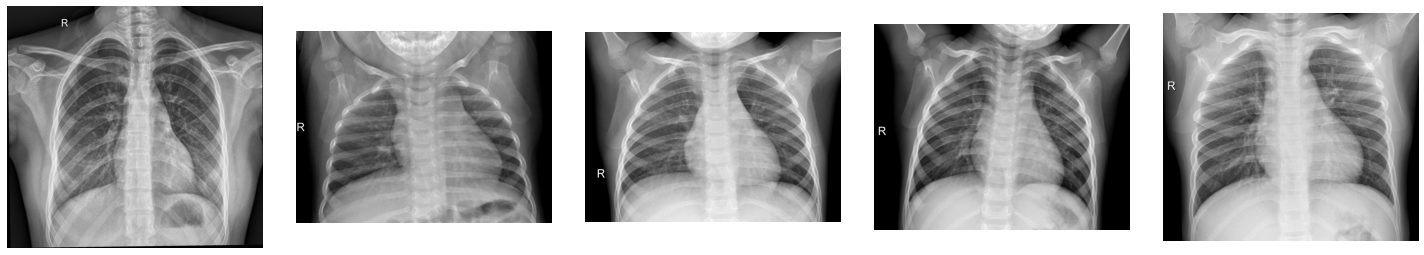

In [5]:
check_image(train_img+'NORMAL')

# Pneumonia X-Ray images

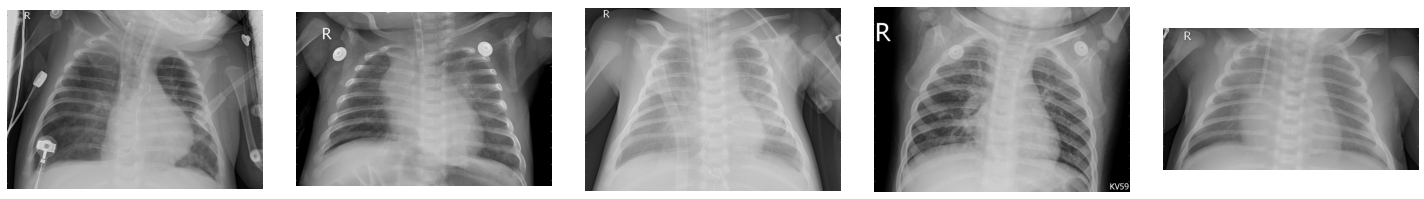

In [5]:
check_image(train_img+'PNEUMONIA')

# Data Generator

In [6]:
data_gen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split = 0.25,
                                   horizontal_flip = True)


train_set = data_gen.flow_from_directory(train_img,target_size = (256, 256),
                                                   batch_size = 5,
                                                   color_mode='grayscale',
                                                   subset='training',
                                                   class_mode = 'binary')

valid_set = data_gen.flow_from_directory(train_img,target_size=(256, 256),
                                                   batch_size=5,
                                                   subset="validation",
                                                   color_mode='grayscale',
                                                   class_mode='binary')

test_set = data_gen.flow_from_directory(test_img,target_size = (256, 256),
                                                 batch_size = 5,
                                                 color_mode='grayscale',
                                                 shuffle=False,
                                                 class_mode = 'binary')

Found 3913 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
train_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [23]:
train_set.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

# BUILDING THE MODEL

In [47]:
model = Sequential()

# CONVOLUTIONAL LAYER # 1
model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=(256, 256, 1), activation='relu',))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))

# *************CONVOLUTIONAL LAYER # 2 
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(256, 256, 1), activation='relu',))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))

# *************CONVOLUTIONAL LAYER # 3
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(256, 256, 1), activation='relu',))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))

# *************CONVOLUTIONAL LAYER # 4
model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=(256, 256, 1), activation='relu',))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))

# FLATTEN IMAGES FROM 200 x 200 x 3 =120000 BEFORE FINAL LAYER
model.add(Flatten())

# 1024 NEURONS IN DENSE HIDDEN LAYER (YOU CAN CHANGE THIS NUMBER OF NEURONS)
model.add(Dense(1024, activation='relu'))

# LAST LAYER IS THE CLASSIFIER, THUS 1 POSSIBLE CLASSES
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 30, 30, 64)      

In [49]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Class Weights

To be more precise, the formula to calculate this is:

wj=n_samples / (n_classes * n_samplesj)



wj = the weight for each class(j signifies the class)

n_samplesis = the total number of samples or rows in the dataset

n_classesis = the total number of unique classes in the target

n_samplesjis = the total number of rows of the respective class

In [50]:
train_count = len(os.listdir(train_img+'NORMAL')) + len(os.listdir(train_img+'PNEUMONIA'))
count_normal = len(os.listdir(train_img+'NORMAL'))
count_pneumonia = len(os.listdir(train_img+'PNEUMONIA'))

weight_for_normal = train_count / (2 * count_normal)
weight_for_pheumonia = train_count / (2 * count_pneumonia)

class_weight = {0: weight_for_normal, 1: weight_for_pheumonia}

In [51]:
print(class_weight) 

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [52]:
history = model.fit(train_set, epochs=30 ,validation_data=valid_set,class_weight=class_weight)

Epoch 1/30
783/783 [==============================] - 203s 258ms/step - loss: 0.4306 - accuracy: 0.7940 - val_loss: 0.2569 - val_accuracy: 0.8979
Epoch 2/30
783/783 [==============================] - 200s 255ms/step - loss: 0.2648 - accuracy: 0.9006 - val_loss: 0.4174 - val_accuracy: 0.8557
Epoch 3/30
783/783 [==============================] - 199s 254ms/step - loss: 0.2416 - accuracy: 0.9075 - val_loss: 0.3547 - val_accuracy: 0.8381
Epoch 4/30
783/783 [==============================] - 200s 255ms/step - loss: 0.2254 - accuracy: 0.9113 - val_loss: 0.2412 - val_accuracy: 0.9025
Epoch 5/30
783/783 [==============================] - 2772s 4s/step - loss: 0.1975 - accuracy: 0.9233 - val_loss: 0.2004 - val_accuracy: 0.9217
Epoch 6/30
783/783 [==============================] - 210s 268ms/step - loss: 0.1930 - accuracy: 0.9264 - val_loss: 0.2047 - val_accuracy: 0.9325
Epoch 7/30
783/783 [==============================] - 203s 259ms/step - loss: 0.1798 - accuracy: 0.9325 - val_loss: 0.2362 - v

In [53]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
metrics = pd.DataFrame(model.history.history)

In [55]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.430602,0.794020,0.256906,0.897928
1,0.264849,0.900588,0.417395,0.855718
2,0.241622,0.907488,0.354748,0.838066
3,0.225446,0.911321,0.241163,0.902533
4,0.197545,0.923332,0.200421,0.921719
5,0.192980,0.926399,0.204712,0.932464
6,0.179824,0.932533,0.236164,0.897160
7,0.179609,0.929721,0.179977,0.937068
8,0.170477,0.931766,0.204619,0.925556
9,0.158692,0.940199,0.245367,0.904835


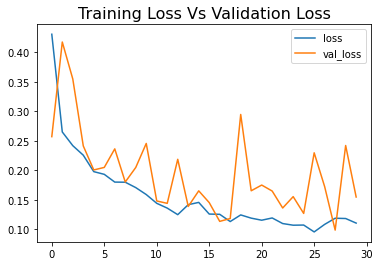

In [56]:
metrics[['loss', 'val_loss']].plot()
plt.title('Training Loss Vs Validation Loss', fontsize=16)
plt.show()

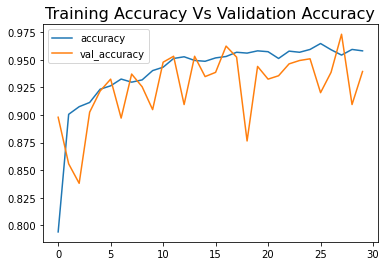

In [57]:
metrics[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy Vs Validation Accuracy', fontsize=16)
plt.show()

In [58]:
model.evaluate(test_set)

125/125 [==============================] - 9s 69ms/step - loss: 0.3145 - accuracy: 0.8830


[0.3145334720611572, 0.8830128312110901]

In [62]:
y_pred = np.round(model.predict(test_set))
y_true = test_set.classes
y_labels = list(test_set.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=y_labels))

              precision    recall  f1-score   support

      NORMAL       0.93      0.75      0.83       234
   PNEUMONIA       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.86      0.87       624
weighted avg       0.89      0.88      0.88       624



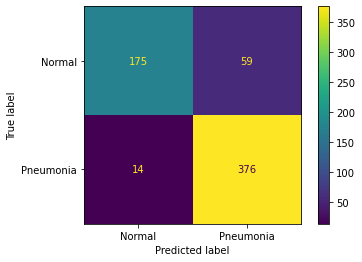

In [63]:
display(ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['Normal', 'Pneumonia']).plot())

In [73]:
model.save('CNN_PNEUMONIA.h8')

INFO:tensorflow:Assets written to: CNN_PNEUMONIA.h8/assets
